# Reconstruction with Keras


In [3]:
from keras.models               import Sequential
from keras.layers               import Dense, Activation, Dropout
from keras.optimizers           import SGD, Adam, Nadam         
from keras                      import callbacks
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers.core          import Flatten

%matplotlib inline
from matplotlib.patches         import Ellipse
import matplotlib.pyplot as plt
import numpy  as np
import random as rd
import tables as tb
import math
import sys

# Add the Utilties directory to the system path so the file sipm_param can be imported.
sys.path.append("../../Core")
from sipm_param import *

# Number of EL points to generate per event.
N_ELpts = 1

Below are a few important switches that determine how the data used and created here are loaded and stored.

In [4]:
Save_hist  = False      # Set to True to save the history of the model
Save_model = False     # Save the neural net (including the learned weights) for future training/teseting

MOD_hist  = True       # if MOD_hist, script will modify existing HISTORY .h file, adding a node in pytable
                       # with loss history
                       # if not MOD_hist, will create a new .h file and do the same thing
                       # **Note if Save_hist is False, MOD_hist does not matter 

# specify file where data is to be read or written (or neither if desired, but not both)          
MC_filename =  'TMC_data.h'          
            
Load_MC = True    # set to true to load existing SiPM response data

if Load_MC:     Save_MC = False   # Save SiPM response/label data only if it doesn't already exist in a .h file
else:           Save_MC = True    # (do not save data that is already saved)

if Save_MC:
    # Must set MOD_data # Set to true to create a new group (for a new N_ELpts) in an existing .h file
    MOD_data = True     # Set to false to create a new .h file entirely (will overwrite existing ifle)
    
ES = False              # set to true to implement early stopping
if ES == True: 
    N_layers = -1       # must specify number of total layers now
    ES_filepath =  'ES_' + str(N_ELpts) + 'hits' + str(N_layers) + 'lay.h'
    print(ES_filepath)

                        

The parameterization is done in two time bins and can be accessed through the function sipm_par(tbin, r) defined in Utilities/sipm_param.py.  Here tbin is the time bin and r is the radial distance from the EL point at which the SiPM of interest is located.

In [5]:
# Geometry definition.
nsipm = 8
sipm_pitch = 10.       # distance between SiPMs
sipm_edge_width = 5.   # distance between SiPM and edge of board

# Variables for computing an EL point location.
xlen = 2*sipm_edge_width + 7*sipm_pitch       # (mm) side length of rectangle
ylen = 2*sipm_edge_width + 7*sipm_pitch       # (mm) side length of rectangle
if xlen == ylen: max_xy = xlen
wbin = 2.0                                    # (mm) bin width

# Compute the positions of the SiPMs.
pos_x = np.ones(nsipm**2)*sipm_edge_width + (np.ones(nsipm*nsipm)*range(nsipm**2) % nsipm)*sipm_pitch
pos_y = np.ones(nsipm**2)*sipm_edge_width + np.floor(np.ones(nsipm*nsipm)*range(nsipm**2) / nsipm)*sipm_pitch

Now load or generate the hits and SiPM response data

In [6]:
# ** All of the parameters listed above must be the same as those used to create the data in f.root.group ** #
# ** This can be changed if needed so that the above parameters are also saved/loaded in the pytable, but ** #
# ** for the moment this seems unnecessary.                                                               ** #
if Load_MC:
    f = tb.open_file(MC_filename, 'r')
    
    # access correct group
    if N_ELpts  == 1: dat_tree = f.root.sim_1pt
    elif N_ELpts ==2: dat_tree = f.root.sim_2pt
    elif N_ELpts ==3: dat_tree = f.root.sim_3pt
    elif N_ELpts ==4: dat_tree = f.root.sim_4pt    
    
    print('-- Loading data from file: ' + MC_filename + ' ...')
    x_train = dat_tree.xtrain[:]
    y_train = dat_tree.ytrain[:]
    x_valid = dat_tree.xvalid[:]
    y_valid = dat_tree.yvalid[:]
    
    Nevts_train = y_train.shape[0]
    Nevts_valid = y_valid.shape[0]
    Nevts = Nevts_train + Nevts_valid
    
    print(dat_tree)
    f.close()
    print('-- Load complete')
    
    
# Generate the data    
else:
    print('-- Generating hits and response data ... ')
    
    # Number of events to generate.
    Nevts_train = 10000  # specify
    Nevts_valid = 1000   # specify

    # Set up the training sets.
    x_train = np.zeros([Nevts_train,nsipm*nsipm]); x_valid = np.zeros([Nevts_valid,nsipm*nsipm])
    y_train = np.zeros([Nevts_train,2*N_ELpts]);   y_valid = np.zeros([Nevts_valid,2*N_ELpts])

    # Generate the events.
    Nevts = Nevts_train + Nevts_valid

    # generate and sort ypts
    Xpts = np.sort(np.random.uniform(0,xlen,(Nevts,N_ELpts)),axis=1)

    for nn in range(Nevts):

        if(nn % int(Nevts/10) == 0):
            print "-- Event {0} of {1} ...".format(nn,Nevts)

        # For each event, generate a number of random EL points and compute the probabilities of detection for each SiPM.
        sipm_map = np.zeros(nsipm*nsipm)
        for npt in range(N_ELpts):

            # Generate the point.
            #xpt = rd.random()*xlen
            xpt = Xpts[nn,npt]
            ypt = rd.random()*ylen

            # Compute the distances and probabilities.  Add the probabilities to the sipm map.
            rr = np.array([math.sqrt((xi - xpt)**2 + (yi - ypt)**2) for xi,yi in zip(pos_x,pos_y)])
            probs = 0.5*(sipm_par(0, rr) + sipm_par(1, rr))
            sipm_map += probs

            # Fill the y matrix with the generated points.
            if(nn >= Nevts_train):
                y_valid[nn-Nevts_train,2*npt] = xpt/xlen
                y_valid[nn-Nevts_train,2*npt+1] = ypt/ylen
            else:
                y_train[nn,2*npt] = xpt/xlen
                y_train[nn,2*npt+1] = ypt/ylen

        # Normalize the probability map, and set sigma = 1.
        sipm_map -= np.mean(sipm_map)
        sipm_map /= np.std(sipm_map)

        # Fill the x matrix for the generated points.
        if(nn >= Nevts_train):
            x_valid[nn-Nevts_train] = sipm_map
        else:
            x_train[nn] = sipm_map

-- Loading data from file: TMC_data.h ...
/sim_1pt (Group) 'Group for 1 ELPTs'
-- Load complete


Save montecarlo data if Save_MC

In [7]:
if Save_MC:
    if MOD_data: 
        f = tb.open_file(MC_filename, 'r+')    # modify
        print('-- Modifying '  +  MC_filename  + ' to contain new montecarlo data ...')
        
    else:  
        f = tb.open_file(MC_filename, 'w')      # else write
        print('-- Writing new ' +  MC_filename   + ' to contain new montecarlo data ...')
        
    
    # compress tables arrays with blosc, but don't shuffle
    filters = tb.Filters(complib='blosc', complevel=9, shuffle=False) 

    groupname = 'sim_' + str(N_ELpts) + 'pt'
    group = f.create_group(f.root, groupname, 'Group for ' + str(N_ELpts) + ' ELPTs') 

    # ** The arrays used here are extensible (EArrays), this means that we can add more data later if we want
    #    so that in the futre we can train on a larger training set. 
    #    To add one SiPM response map to the training data you would open the table in the .h file,
    #    access the correct group, and then maps to xdat.
    #    For example, to append one map to the training data with 3 E_LPts you would write:
    #    f.root.sim_3pt.xtrain.append([map]) when map is a numpy ndarray with one dimension of size nsipm^2 
    
    atom = tb.Atom.from_dtype(x_train.dtype) 
    xtrain = f.create_earray(group, 'xtrain', atom, (0,nsipm**2),  filters=filters, expectedrows=Nevts_train)
    
    atom = tb.Atom.from_dtype(y_train.dtype) 
    ytrain = f.create_earray(group, 'ytrain', atom, (0,2*N_ELpts), filters=filters, expectedrows=Nevts_train)    
    
    atom = tb.Atom.from_dtype(x_valid.dtype) 
    xvalid = f.create_earray(group, 'xvalid', atom, (0,nsipm**2),  filters=filters, expectedrows=Nevts_valid)   

    atom = tb.Atom.from_dtype(y_valid.dtype) 
    yvalid = f.create_earray(group, 'yvalid', atom, (0,2*N_ELpts), filters=filters, expectedrows=Nevts_valid)
    
    print('-- Saving training data ...')
    
    #Now put the data in the arrays
    for ev in range(Nevts_train):
        xtrain.append([x_train[ev]])
        ytrain.append([y_train[ev]])
    
    print('-- Saving validation data ...')
    
    for ev in range(Nevts_valid):
        xvalid.append([x_valid[ev]])
        yvalid.append([y_valid[ev]])
    
    print(f)
    f.close()

Define some networks

In [19]:
def cnn():
    model = Sequential()
 
    # **Worth taking into consideration that our image size is tiny (8x8), convolution may work much better for 
    # **with 1792 sipms
    
    # kernal size is 3x3, 32 filters, padding is same.
    # Same padding works better, this is probably because same padding makes it easier for network no to retain as
    # much information as possible around the edges. 
    model.add(Convolution2D(32,3,3,border_mode='same',input_shape=(1, nsipm, nsipm)))
    model.add(Activation('relu'))
    model.add(Convolution2D(32,3,3,border_mode='same', input_shape=(32, nsipm, nsipm)))
    model.add(Activation('relu'))
    #model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(output_dim=128))
    model.add(Activation('relu'))      
    model.add(Dense(output_dim=64))
    model.add(Activation('relu'))  
    model.add(Dense(output_dim=2*N_ELpts))
    model.add(Activation('sigmoid'))

    # Nadam optimizer is a safe choice at least for deep networks. It is adam optimizer with Nesterov
    # Momentum. Nesterov Momentum takes into account future expected future gradient gradient, unlike traditional Mom.
    model.compile(loss='mse', optimizer=Nadam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=1e-08, schedule_decay=0.004))
    N_layers = 'cnn'
    return model,N_layers
    


# construct a 5 layer network
def lay5():
    model = Sequential()
    model.add(Dense(output_dim=2048, input_dim=nsipm*nsipm))
    model.add(Activation("relu"))
    model.add(Dense(output_dim=1024))
    model.add(Activation("relu"))
    model.add(Dense(output_dim=512))
    model.add(Activation("relu"))
    model.add(Dense(output_dim=256))
    model.add(Activation("relu"))
    model.add(Dropout(.25))    # **Note this is drop rate, not keep rate (like in tf)
    model.add(Dense(output_dim=2*N_ELpts))
    model.add(Activation("sigmoid"))
    
    # Nadam optimizer is probabaly a safe choice at least for our deep networks. It is adam optimizer with Nesterov
    # Momentum. Nesterov Momentum takes into account future expected future gradient gradient, unlike traditional Mom.
    model.compile(loss='mse', optimizer=Nadam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=1e-08, schedule_decay=0.004))
    model.summary()
    N_layers = 5
    return model,N_layers
    
# construct a 4 layer network
def lay4():
    model = Sequential()
    model.add(Dense(output_dim=2048, input_dim=nsipm*nsipm))
    model.add(Activation("relu"))
    model.add(Dense(output_dim=1024))
    model.add(Activation("relu"))
    model.add(Dense(output_dim=512))
    model.add(Activation("relu"))
    model.add(Dropout(.2))
    model.add(Dense(output_dim=2*N_ELpts))
    model.add(Activation("sigmoid"))
    model.compile(loss='mse', optimizer=Nadam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=1e-08, schedule_decay=0.004))
    model.summary()
    N_layers = 4
    return model,N_layers
    
# etc .. 
def lay3():
    model = Sequential()
    model.add(Dense(output_dim=2048, input_dim=nsipm*nsipm))
    model.add(Activation("relu"))
    model.add(Dense(output_dim=1024))
    model.add(Activation("relu"))
    #model.add(Dropout(.15))
    model.add(Dense(output_dim=2*N_ELpts))
    model.add(Activation("sigmoid"))
    #model.compile(loss='mse', optimizer=SGD(lr=1.0, momentum=0.9, nesterov=True))
    model.compile(loss='mse', optimizer=Nadam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=1e-08, schedule_decay=0.004))

    model.summary()
    N_layers = 3
    return model,N_layers

def lay2():
    model = Sequential()
    model.add(Dense(output_dim=2048, input_dim=nsipm*nsipm))
    model.add(Activation("relu"))
    #model.add(Dropout(.25))
    model.add(Dense(output_dim=2*N_ELpts))
    model.add(Activation("sigmoid"))
    model.compile(loss ='mse',  optimizer=SGD(lr=1.0, momentum=0.9, nesterov=True))
    #model.compile(loss='mse', optimizer=Nadam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=1e-08, schedule_decay=0.004))
    model.summary()
    N_layers = 2
    return model,N_layers
    
def lay1():
    model = Sequential()
    model.add(Dense(output_dim=2*N_ELpts, input_dim=nsipm**2))
    model.add(Activation("sigmoid"))
    model.compile(loss='mse', optimizer=SGD(lr=1.0, momentum=0.9, nesterov=True))
    model.summary()
    N_layers = 1
    return model,N_layers



Call layered a network and begin training

In [20]:
# call desired network
model,N_layers = cnn()

# stop early and save best model
if ES and Save_model:
    callbacks = [
        callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min'), # stop training if val_loss 
                                                                             # stops decreasing for 3 epochs
        
        callbacks.ModelCheckpoint(ES_filepath, monitor='val_loss', save_best_only=True, mode='min')] # save best model
# stop early do not save    
elif ES:
    callbacks =[callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min')]

# do not stop early, decide whether to save later *use this when comparing error of different numbers of layers
else: callbacks =[]

if N_layers == 'cnn':
    hist = model.fit(x_train.reshape((Nevts_train,1,nsipm,nsipm)), y_train, nb_epoch=20, batch_size=100,  
                 validation_data=(x_valid.reshape((Nevts_valid,1,nsipm,nsipm)),y_valid),
                 verbose=2, callbacks=callbacks);  
else:
    hist = model.fit(x_train, y_train, nb_epoch=20, batch_size=100,  
                 validation_data=(x_valid,y_valid),
                 verbose=2, callbacks=callbacks);  

Train on 10000 samples, validate on 1000 samples
Epoch 1/20
3s - loss: 0.0030 - val_loss: 3.7360e-04
Epoch 2/20
3s - loss: 4.2517e-04 - val_loss: 3.0837e-04
Epoch 3/20
3s - loss: 3.1392e-04 - val_loss: 2.0447e-04
Epoch 4/20
3s - loss: 2.4065e-04 - val_loss: 6.4546e-05
Epoch 5/20
3s - loss: 1.1560e-04 - val_loss: 1.2208e-04
Epoch 6/20
3s - loss: 2.0469e-04 - val_loss: 3.0526e-04
Epoch 7/20
3s - loss: 1.8033e-04 - val_loss: 2.1779e-04
Epoch 8/20
3s - loss: 6.1510e-05 - val_loss: 4.9076e-05
Epoch 9/20
3s - loss: 1.5031e-04 - val_loss: 3.3290e-05
Epoch 10/20
3s - loss: 1.0528e-04 - val_loss: 3.2209e-05
Epoch 11/20
3s - loss: 6.9076e-05 - val_loss: 4.0382e-05
Epoch 12/20
3s - loss: 1.6848e-04 - val_loss: 2.5819e-05
Epoch 13/20
3s - loss: 2.8428e-05 - val_loss: 3.8277e-05
Epoch 14/20
3s - loss: 7.9812e-05 - val_loss: 1.3208e-04
Epoch 15/20
3s - loss: 6.0282e-05 - val_loss: 2.6194e-05
Epoch 16/20
3s - loss: 4.7630e-05 - val_loss: 2.1880e-05
Epoch 17/20
3s - loss: 9.2380e-05 - val_loss: 2.5239

Study the network a little with some plots:

Below is a plot of training and validation error over epochs

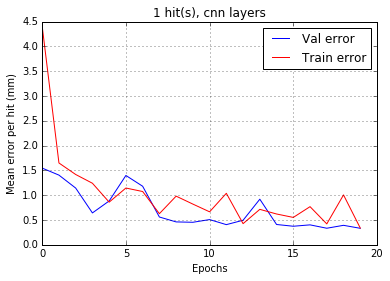

In [21]:
val   = plt.plot(range(0,len(hist.history['loss'])),
                 np.sqrt(np.array(hist.history['val_loss'])/N_ELpts)*max_xy, 'b', label='Val error')
train = plt.plot(range(0,len(hist.history['loss'])),
                 np.sqrt(np.array(hist.history['loss'])    /N_ELpts)*max_xy, 'r', label='Train error')
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Mean error per hit (mm)')
plt.title(str(N_ELpts) + ' hit(s), ' + str(N_layers) +' layers')
plt.grid(True)
plt.show()

Error in x and in y as a function of the x and y coordinate of the hit

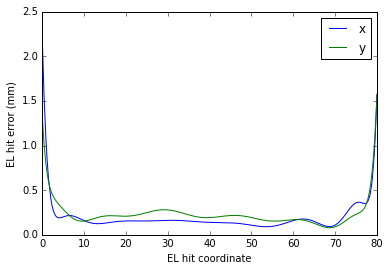

In [24]:
# Get model's predictions, plot the error in a histogram
if N_layers == 'cnn':
    predictions = model.predict(x_valid.reshape((Nevts_valid,1,nsipm,nsipm)))
else: 
    predictions = model.predict(x_valid)
    
st = (predictions - y_valid)**2

xerr = abs(predictions[:,0] - y_valid[:,0])*max_xy
yerr = abs(predictions[:,1] - y_valid[:,1])*max_xy

# could replace these best fit lines with something average data points
# x, y error as a function of x, y  EL hit coordinate
#plt.scatter(y_valid[0:10,0]*max_xy,xerr[0:10],color='b') # sample points
#plt.scatter(y_valid[0:10,1]*max_xy,yerr[0:10],color='g') # sample points
bestfitx = plt.plot(np.unique(y_valid[:,0]*max_xy), np.poly1d(np.polyfit(y_valid[:,0]*max_xy,xerr, 15))(np.unique(y_valid[:,0]*max_xy)),label='x')
bestfitx = plt.plot(np.unique(y_valid[:,1]*max_xy), np.poly1d(np.polyfit(y_valid[:,1]*max_xy,yerr, 15))(np.unique(y_valid[:,1]*max_xy)),label='y')
plt.legend(loc='upper right')
plt.xlabel('EL hit coordinate')
plt.ylabel('EL hit error (mm)')
plt.show()

# Note: x coord is used to order hits for training (relavent when N_ELpts > 1)

Mean error with 1 hit (mm): 1.31021632244


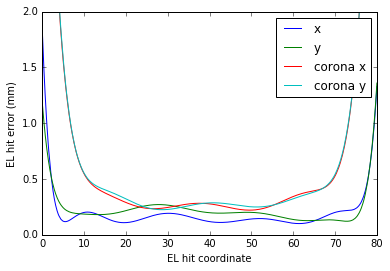

In [43]:
# Get model's predictions, plot the error in a histogram
sys.path.append('../../ToyDNN')
from toy_corona import *
(cxc,cxe,cyc,cye) = toy_corona_error('TMC_data.h')




if N_layers == 'cnn':
    predictions = model.predict(x_valid.reshape((Nevts_valid,1,nsipm,nsipm)))
else: 
    predictions = model.predict(x_valid)
    
st = (predictions - y_valid)**2

xerr = abs(predictions[:,0] - y_valid[:,0])*max_xy
yerr = abs(predictions[:,1] - y_valid[:,1])*max_xy

# could replace these best fit lines with something average data points
# x, y error as a function of x, y  EL hit coordinate
#plt.scatter(y_valid[0:10,0]*max_xy,xerr[0:10],color='b') # sample points
#plt.scatter(y_valid[0:10,1]*max_xy,yerr[0:10],color='g') # sample points
bestfitx  = plt.plot(np.unique(y_valid[:,0]*max_xy), np.poly1d(np.polyfit(y_valid[:,0]*max_xy,xerr, 10))(np.unique(y_valid[:,0]*max_xy)),label='x')
bestfity  = plt.plot(np.unique(y_valid[:,1]*max_xy), np.poly1d(np.polyfit(y_valid[:,1]*max_xy,yerr, 10))(np.unique(y_valid[:,1]*max_xy)),label='y')
bestfitcx = plt.plot(np.unique(cxc), np.poly1d(np.polyfit(cxc,cxe, 9))(np.unique(cxc)),label='corona x')
bestfitcy = plt.plot(np.unique(cyc), np.poly1d(np.polyfit(cyc,cye, 9))(np.unique(cyc)),label='corona y')
plt.legend(loc='upper right')
plt.xlabel('EL hit coordinate')
plt.ylabel('EL hit error (mm)')
plt.ylim([0,2])
plt.show()

# Note: x coord is used to order hits for training (relavent when N_ELpts > 1)

Here is a histogram of the error

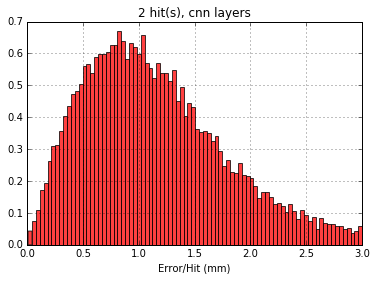

In [25]:
E = np.empty((Nevts_valid,N_ELpts))
for pt in range(N_ELpts):
    E[:,pt] = np.sqrt(st[:,2*pt] + st[:,2*pt+1])*max_xy

# plot the histogram, of average error per point in distance
n, bins, patches = plt.hist(E.flatten(), 2000, color='red', normed=1, alpha=0.75)
plt.xlim(0,3)
plt.xlabel('Error/Hit (mm)')
plt.grid(True)
plt.title(str(N_ELpts) + ' hit(s), ' + str(N_layers) +' layers')
plt.show()

Plot error as a function of the distance of the EL hit from the center of the EL plane (40,40) 

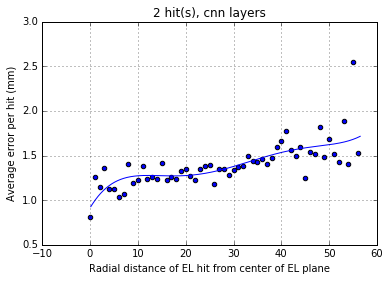

In [64]:
from collections import defaultdict
dd=defaultdict(int) # defaultdict whose keys are distance from 40,40, whose values are error
dn=defaultdict(int) # defaultdict whose keys are distance from 40,40, whose values are the number of evts 
                    # with that distance

for ev in range(Nevts_valid):
    for pt in range(N_ELpts):
        dist = np.sqrt((y_valid[ev,2*pt]*xlen-40)**2 + (y_valid[ev,2*pt+1]*ylen-40)**2)
        dd[dist] += E[ev,pt]
        dn[dist] += 1

for key in dd: dd[key] /= dn[key]

# this line is pretty meaningless since I am picking the degree polynomial --------->
bestfit = plt.plot(np.unique(dd.keys()), np.poly1d(np.polyfit(dd.keys(),dd.values(), 5))(np.unique(dd.keys())))

# bin error for plotting
bins = defaultdict(int)
no   = defaultdict(int)
for key in dd:
    bins[round(key)] += dd[key]
    no[round(key)]   += 1
for key in bins: bins[key] /= no[key]   
plt.scatter(bins.keys(),bins.values())

plt.xlabel('Radial distance of EL hit from center of EL plane')
plt.ylabel('Average error per hit (mm)')
plt.title(str(N_ELpts) + ' hit(s), ' + str(N_layers) +' layers')
plt.grid(True)
plt.show()

Plot a training event

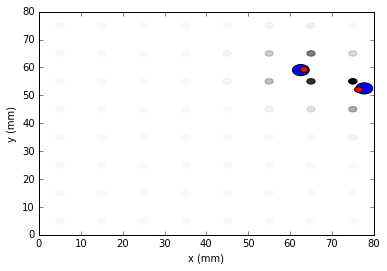

In [53]:
# Plot one event.
plt_train = False
pevt = np.random.randint(0,Nevts_valid)
fig = plt.figure();
ax1 = fig.add_subplot(111);
ax1.axis([0, xlen, 0, ylen]);

if(plt_train):
    xarr = x_train[pevt]
    yarr = y_train[pevt]
else:
    xarr = x_valid[pevt]
    yarr = y_valid[pevt]

# Create circles and plot them according to the probabilities.
probs = (xarr - min(xarr))
probs /= max(probs)
for x,y,p in zip(pos_x, pos_y, probs):

    #print "Placing sipm at ({0},{1}) with prob {2}".format(x,y,p);
    
    # Set up the location; note we must invert y due to a pi rotation
    #  about the x-axis.
    r = Ellipse(xy=(x,y), width=2., height=2.);
    r.set_facecolor('0');
    r.set_alpha(0.02 + 0.98*p);
    ax1.add_artist(r);

# Place large blue circles for actual EL points.
for npt in range(len(yarr)/2):
    xpt = yarr[2*npt]*xlen
    ypt = yarr[2*npt+1]*ylen
    mrk = Ellipse(xy=(xpt,ypt), width=4., height=4.);
    mrk.set_facecolor('b');
    ax1.add_artist(mrk);
    
# Place small red circles for predicted EL points.
for npt in range(len(predictions[pevt])/2):
    xpt = predictions[pevt][2*npt]*xlen
    ypt = predictions[pevt][2*npt+1]*ylen
    mrk = Ellipse(xy=(xpt,ypt), width=2., height=2.);
    mrk.set_facecolor('r');
    ax1.add_artist(mrk);

# Show the plot.
plt.xlabel("x (mm)");
plt.ylabel("y (mm)");
plt.show()

Compare with other machine learning tools:

In [13]:
from sklearn.linear_model import LinearRegression
linreg = LinearRegression()
linreg_model = linreg.fit(x_train, y_train)
print('----training now----')
print('LinReg Error in mm/hit: '  + str(
        np.sqrt(np.sum((linreg_model.predict(x_valid) - y_valid)**2/N_ELpts/y_valid.shape[0])) * max_xy) )

/usr/local/lib/python2.7/site-packages/scipy/linalg/basic.py:884: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


----training now----
LinReg Error in mm/hit: 16.1953514159


Save the model if not already saved:

In [14]:
if not ES and Save_model: 
    model_filename = str(N_ELpts) + 'hit' + str(N_layers) +'lay.h'
    model.save(model_filename)

Also save the history for DNNcomparison:

In [15]:
hist_filename = 'hist_' + str(N_ELpts) + 'hit.h'

if Save_hist and not ES: # Can get rid of 'and not ES', but at the moment i dont want to keep the history 
                         # for comparison if each of the histories will have different numbers of epochs
        
    if MOD_hist: f = tb.open_file(hist_filename, 'r+')
    else:        f = tb.open_file(hist_filename, 'w' )

    filters = tb.Filters(complib='blosc', complevel=9, shuffle=False) # define tables filters
    if N_layers == 'cnn': arrayname = 'cnn'
    else: arrayname = str(N_layers) + 'lay'                           # define new array name, (could be carray)
    
    # put history in ndarray
    val_err_hist = np.sqrt(np.array(hist.history['val_loss'])/N_ELpts)*max_xy
    
    # put ndarray in tables earray
    atom = tb.Atom.from_dtype(val_err_hist.dtype)
    err_hist = f.create_earray(f.root,arrayname, atom, (0,val_err_hist.shape[0]), filters=filters)
    err_hist.append([val_err_hist])

In [16]:
if Save_hist and not ES:
    print(f)
    f.close()

hist_2hit.h (File) ''
Last modif.: 'Tue Sep  6 21:30:05 2016'
Object Tree: 
/ (RootGroup) ''
/1lay (EArray(1, 20), blosc(9)) ''
/2lay (EArray(1, 20), blosc(9)) ''
/3lay (EArray(1, 20), blosc(9)) ''
/4lay (EArray(1, 20), blosc(9)) ''
/5lay (EArray(1, 20), blosc(9)) ''
/cnn (EArray(1, 20), blosc(9)) ''



In [17]:
# To remove a node:

#f = tb.open_file(hist_filename, 'r+')
#f.root.cnn2._f_remove() 
#print(f)
#f.close()
